In [1]:
import os

import absl.logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set ABSL logging to ERROR to suppress warnings (only show errors)
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# Necessary imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:

# Load the dataset
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

data.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Separating features and target
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Encoding target variable: Malignant (M) as 1, Benign (B) as 0
y = np.where(y == "M", 1, 0)

# Split the dataset to keep aside 100 samples from each class for testing
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]
y_class_0 = y[class_0_indices]
y_class_1 = y[class_1_indices]

# Separate 100 samples from each class for the test set
X_test_class_0, X_train_class_0 = X_class_0[:100], X_class_0[100:]
X_test_class_1, X_train_class_1 = X_class_1[:100], X_class_1[100:]
y_test_class_0, y_train_class_0 = y_class_0[:100], y_class_0[100:]
y_test_class_1, y_train_class_1 = y_class_1[:100], y_class_1[100:]

# Combine the class-separated training and test sets
X_train = np.concatenate((X_train_class_0, X_train_class_1))
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_test_small = np.concatenate((X_test_class_0, X_test_class_1))
y_test_small = np.concatenate((y_test_class_0, y_test_class_1))



In [5]:

np.random.seed(42)

# Determine the number of samples in the minority class
minority_class_size = min(len(X_train_class_0), len(X_train_class_1))

# Calculate the number of samples to duplicate from the majority class
majority_class_size = 3 * minority_class_size - len(X_train_class_1)

# Randomly select samples to duplicate from the majority class
indices_to_duplicate = np.random.choice(len(X_train_class_1), majority_class_size, replace=True)

# Extract the samples to be duplicated
X_to_duplicate = X_train_class_1[indices_to_duplicate]
y_to_duplicate = y_train_class_1[indices_to_duplicate]

# Add noise to the duplicated samples
noise_factor = 0.01
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_to_duplicate.shape)
X_to_duplicate_noisy = X_to_duplicate + noise

# Combine the original training data with the noisy duplicates
X_train_imbalanced = np.vstack((X_train, X_to_duplicate_noisy))
y_train_imbalanced = np.hstack((y_train, y_to_duplicate))





In [6]:
# Calculate the number of labels to flip for each class
num_to_flip_class_0 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 0]))
num_to_flip_class_1 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 1]))

# Randomly choose the indices of labels to flip
indices_to_flip_class_0 = np.random.choice(np.where(y_train_imbalanced == 0)[0], num_to_flip_class_0, replace=False)
indices_to_flip_class_1 = np.random.choice(np.where(y_train_imbalanced == 1)[0], num_to_flip_class_1, replace=False)

# Flip the labels
y_train_imbalanced[indices_to_flip_class_0] = 1
y_train_imbalanced[indices_to_flip_class_1] = 0

print(X_train_imbalanced.shape[1])
print(y_train_imbalanced.shape[0])

print(X_test_small.shape[1])
print(y_test_small.shape[0])


30
593
30
200


In [7]:

# Determine the number of input features (number of columns in X_train_imbalanced)
input_dim = X_train_imbalanced.shape[1]
print(input_dim)

# Create the neural network model with one hidden layer of size twice the number of input features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and the ADAM optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


30


7/7 [==============================] - 0s 314us/step


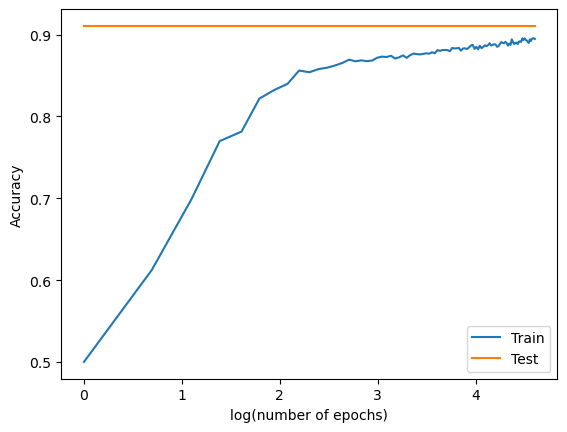

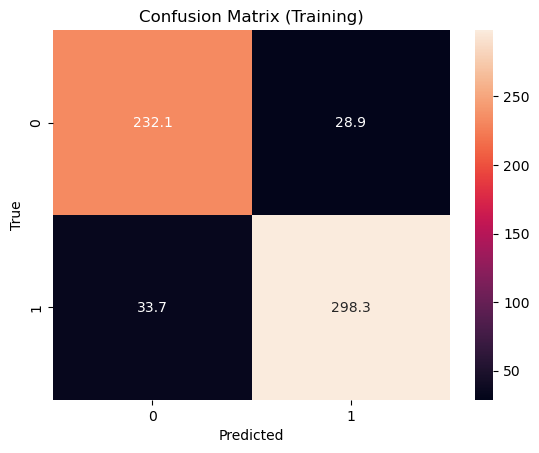

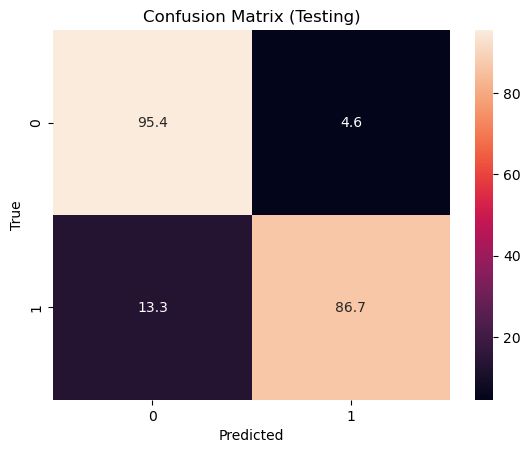

In [8]:


results_train = []
results_test = []
conf_mat_train = []
conf_mat_test = []
weights_list = []

for i in range(10): 
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Save the weights
    weights = model.get_weights()
    weights_list.append(weights)

    # Evaluate the model
    train_acc = history.history['accuracy']
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Save the results
    results_train.append(train_acc)
    results_test.append(test_acc)

    # Confusion matrices
    y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
    y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)

    conf_mat_train.append(confusion_matrix(y_train_imbalanced, y_pred_train))
    conf_mat_test.append(confusion_matrix(y_test_small, y_pred_test))

# Calculate the mean results
mean_results_train = np.mean(results_train, axis=0)
mean_results_test = np.mean(results_test)

# Plot the results
plt.plot(np.log(range(1, 101)), mean_results_train, label="Train")
plt.plot(np.log(range(1, 101)), [mean_results_test] * 100, label="Test")
plt.xlabel("log(number of epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion matrices
mean_conf_mat_train = np.mean(conf_mat_train, axis=0)
mean_conf_mat_test = np.mean(conf_mat_test, axis=0)

# Plotting confusion matrices
plt.figure()
sns.heatmap(mean_conf_mat_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Training)")
plt.show()

plt.figure()
sns.heatmap(mean_conf_mat_test, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Testing)")
plt.show()

# Saving weights
file = open('weights.txt', 'w')
file.write(str(weights_list))
file.close()


7/7 [==============================] - 0s 348us/step


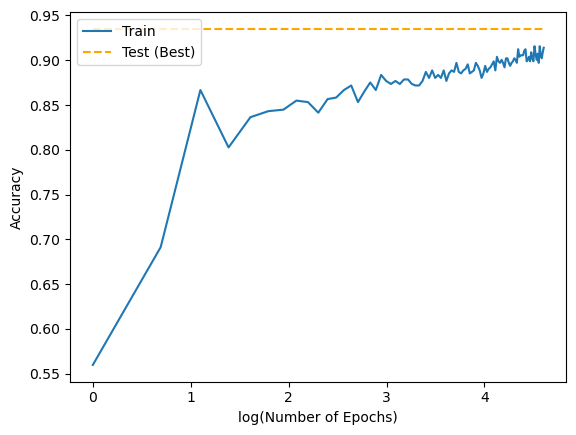

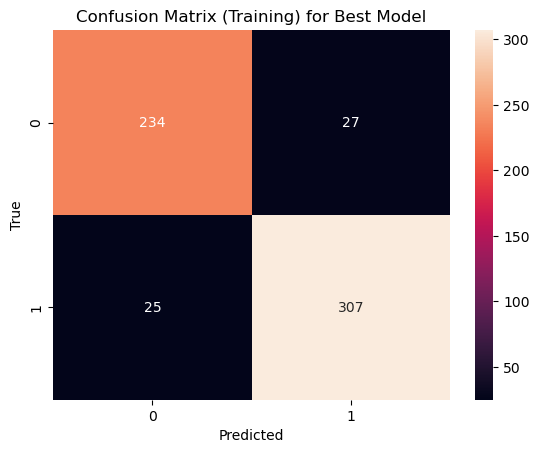

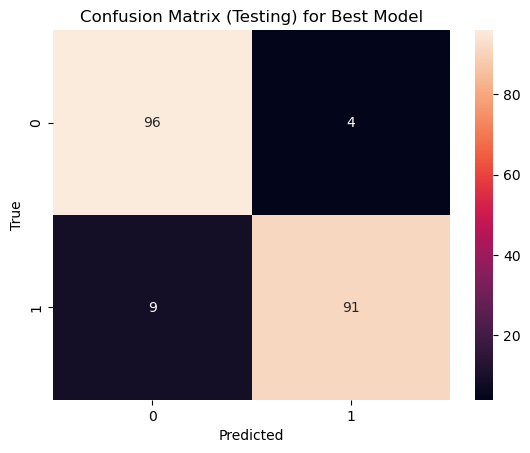

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

best_test_acc = 0  # Initialize the best test accuracy
best_model = None  # Placeholder for the best model
best_weights = None  # Placeholder for the best model's weights
best_epoch_acc = None  # Placeholder for the best model's epoch accuracy
best_conf_mat_train = None  # Placeholder for the best model's training confusion matrix
best_conf_mat_test = None  # Placeholder for the best model's testing confusion matrix

for i in range(10):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Evaluate the model
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Update the best model if the current one is better
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = model
        best_weights = model.get_weights()
        best_epoch_acc = history.history['accuracy']
        
        # Confusion matrices for the best model
        y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
        y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)
        best_conf_mat_train = confusion_matrix(y_train_imbalanced, y_pred_train)
        best_conf_mat_test = confusion_matrix(y_test_small, y_pred_test)

# Plot the results for the best model
plt.plot(np.log(range(1, 101)), best_epoch_acc, label="Train")
plt.hlines(best_test_acc, xmin=0, xmax=np.log(100), colors='orange', linestyles='dashed', label="Test (Best)")
plt.xlabel("log(Number of Epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plotting confusion matrices for the best model
plt.figure()
sns.heatmap(best_conf_mat_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Training) for Best Model")
plt.show()

plt.figure()
sns.heatmap(best_conf_mat_test, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Testing) for Best Model")
plt.show()

# Saving weights of the best model
with open('weights_best_model.txt', 'w') as file:
    file.write(str(best_weights))


In [12]:
def fitness_function(num_neurons):
    tf.keras.backend.clear_session()  # Clear any leftover model state
    num_neurons = int(num_neurons[0])  # Ensure num_neurons is an integer

    # Verify dataset availability and shapes
    assert X_train_imbalanced.ndim == 2, "Check X_train_imbalanced shape"
    assert y_train_imbalanced.ndim == 1, "Check y_train_imbalanced shape"
    assert X_test_small.ndim == 2, "Check X_test_small shape"
    assert y_test_small.ndim == 1, "Check y_test_small shape"

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(num_neurons, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Proceed with model fitting and evaluation
    model.fit(X_train_imbalanced, y_train_imbalanced, epochs=10, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test_small, y_test_small, verbose=0)
    
    return accuracy


In [13]:
import numpy as np

def differential_evolution(fitness_func, bounds, max_gen, pop_size, F=0.6, CR=0.7):
    # Initialize population
    pop = np.random.rand(pop_size, len(bounds))
    pop_denorm = np.array([bounds[:, 0] + individual * (bounds[:, 1] - bounds[:, 0]) for individual in pop])
    fitness = np.asarray([fitness_func(ind) for ind in pop_denorm])
    best_idx = np.argmax(fitness)
    best = pop_denorm[best_idx]
    best_fitness_history = [fitness[best_idx]]
    
    print(f"Initial population fitness: {fitness}")
    print(f"Initial best index: {best_idx}, Fitness: {fitness[best_idx]}")
    
    for gen in range(max_gen):
        print(f"\n--- Generation {gen+1}/{max_gen} ---")
        for i in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F * (b - c), 0, 1)
            cross_points = np.random.rand(len(bounds)) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, len(bounds))] = True
                
            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = bounds[:, 0] + trial * (bounds[:, 1] - bounds[:, 0])
            f = fitness_func(trial_denorm)
            
            if f > fitness[i]:
                fitness[i] = f
                pop[i] = trial
                print(f"Individual {i}: Fitness improved to {fitness[i]}")
                
                if f > fitness[best_idx]:
                    best_idx = i
                    best = trial_denorm
                    print(f"New best found: Index {best_idx}, Fitness: {fitness[best_idx]}")
                    best_fitness_history.append(fitness[best_idx])
    
    print(f"\nBest solution found: Index {best_idx}, Fitness: {fitness[best_idx]}")
    
    # Plotting the convergence
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, marker='o')
    plt.title('Best Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.show()
    return best


Initial population fitness: [0.89999998 0.5        0.88999999 0.5        0.89999998 0.88499999
 0.89999998 0.92000002 0.91000003 0.89999998]
Initial best index: 7, Fitness: 0.9200000166893005

--- Generation 1/500 ---
Individual 0: Fitness improved to 0.9100000262260437
Individual 1: Fitness improved to 0.9100000262260437
Individual 3: Fitness improved to 0.9150000214576721
Individual 5: Fitness improved to 0.9200000166893005
Individual 9: Fitness improved to 0.9150000214576721

--- Generation 2/500 ---
Individual 2: Fitness improved to 0.9150000214576721
Individual 6: Fitness improved to 0.9049999713897705

--- Generation 3/500 ---
Individual 0: Fitness improved to 0.9150000214576721
Individual 1: Fitness improved to 0.9150000214576721
Individual 2: Fitness improved to 0.925000011920929
New best found: Index 2, Fitness: 0.925000011920929
Individual 4: Fitness improved to 0.9150000214576721
Individual 8: Fitness improved to 0.925000011920929

--- Generation 4/500 ---
Individual 0: Fitn

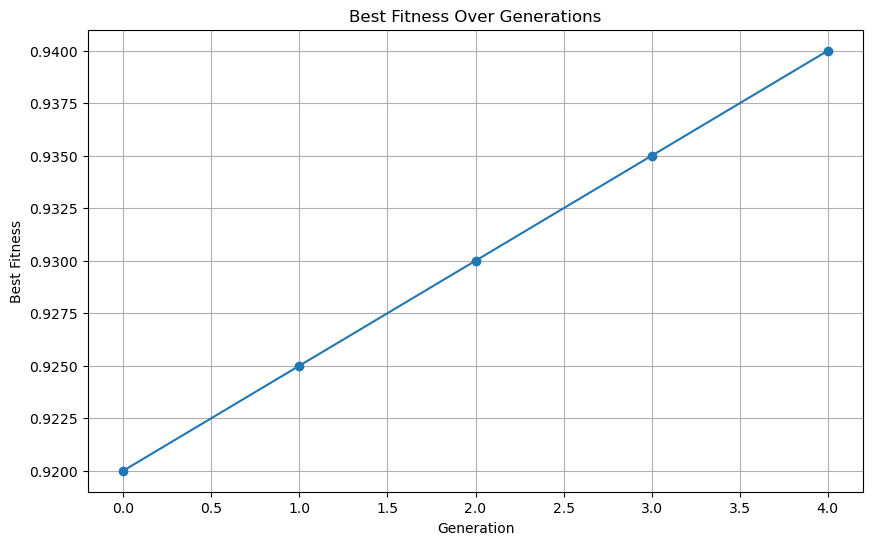

Best Number of Neurons: 74


In [14]:
# Define bounds for the number of neurons
bounds = np.array([[10, 100]])    # Bounds for number of neurons in the hidden layer

# Run DE
best_hyperparams = differential_evolution(fitness_function, bounds, max_gen=500, pop_size=10)

print(f"Best Number of Neurons: {int(best_hyperparams[0])}")

74
7/7 [==============================] - 0s 356us/step


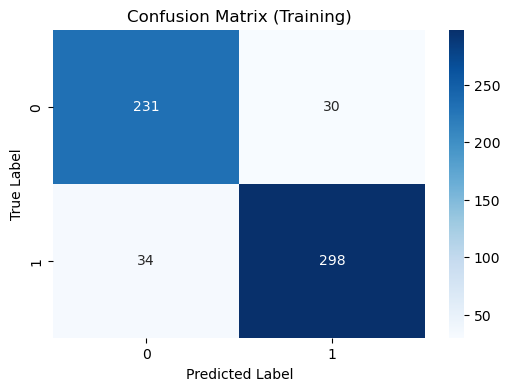

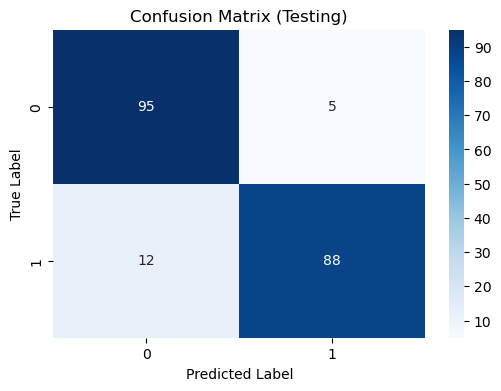

In [16]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# The best number of neurons as found by your DE optimization
best_num_neurons = int(best_hyperparams[0])
print(best_num_neurons)

# Define and compile the model with the best number of neurons
model = tf.keras.Sequential([
    tf.keras.layers.Dense(best_num_neurons, input_dim=X_train_imbalanced.shape[1], activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

# Predictions for training data
y_pred_train = model.predict(X_train_imbalanced)
y_pred_train = (y_pred_train > 0.5).astype(int)

# Predictions for testing data
y_pred_test = model.predict(X_test_small)
y_pred_test = (y_pred_test > 0.5).astype(int)

# Generating confusion matrices
conf_matrix_train = confusion_matrix(y_train_imbalanced, y_pred_train)
conf_matrix_test = confusion_matrix(y_test_small, y_pred_test)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(conf_matrix_train, title='Confusion Matrix (Training)')
plot_confusion_matrix(conf_matrix_test, title='Confusion Matrix (Testing)')
